In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from collections import OrderedDict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def get_config():
    return {
        'batch_size': 64,
        'learning_rate': 1e-3,
        'n_epoch': 10,
        'hidden_sizes': [512,128,32],
    }

config = get_config()

In [4]:
# Load MNIST dataset from torchvision
import torchvision
from torchvision import transforms

train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train = True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train = False,
                                          transform=transforms.ToTensor())


In [5]:
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size = config['batch_size'],
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,
                                               batch_size = config['batch_size'],
                                               shuffle=False)
train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)

In [6]:
examples = iter(train_dataloader)
sample_data, sample_label = next(examples) # one batch train data
print(sample_data.size(), sample_label.size())

torch.Size([64, 1, 28, 28]) torch.Size([64])


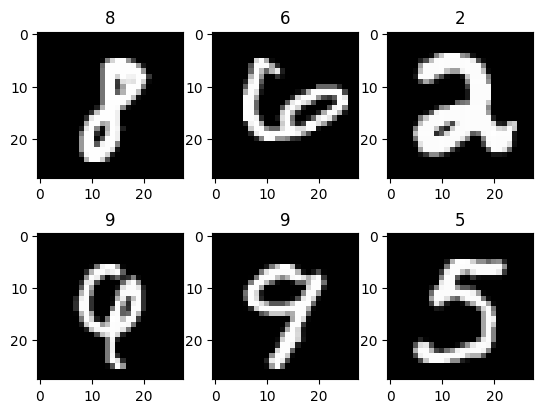

In [7]:
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.title(sample_label[i].numpy())
    plt.imshow(sample_data[i][0], cmap='gray')

In [8]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.layer_dims = [input_size] + hidden_layers + [output_size]
        self.output_size = output_size
        self.model = None
        
    def build(self):
        self.layers = OrderedDict()
        for i in range(1, len(self.layer_dims)):
            self.layers[f'linear{i}'] = nn.Linear(self.layer_dims[i-1], self.layer_dims[i])
            if i < len(self.layer_dims) - 1:
                self.layers[f'relu{i}'] = nn.ReLU()
        self.model = nn.Sequential(self.layers)
        # print(self.model)
        
    def forward(self, x):
        if not self.model:
            self.build()
        return self.model(x)
        

In [9]:
dnn = DNN(784, [512, 128, 32], 10)
dnn.build()
dnn = dnn.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr = config['learning_rate'])

In [10]:
next(dnn.parameters()).is_cuda

True

In [11]:
for epoch in range(config['n_epoch']):
    print(f'--------------Epoch {epoch+1}---------------')
    train_epoch_loss = []
    train_epoch_acc = []
    for i_batch, batch in enumerate(train_dataloader):
        y_true = batch[1].to(device)
        X = batch[0].reshape(batch[0].shape[0],-1).to(device)
        y_logits = dnn(X)
        y_pred = torch.argmax(y_logits,-1)
        
        loss = loss_fn(y_logits, y_true)
        train_epoch_loss.append(loss.cpu().detach().numpy())
        train_epoch_acc.append((y_pred==y_true).cpu().numpy().mean())
        if i_batch % 100 == 0:  # print loss every 100 batches
            print(f'Batch train loss: {loss:.5f}, [{(i_batch+1) * batch[0].shape[0]}/{train_size} examples]') 
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    test_epoch_loss = []
    test_epoch_acc = []
    for i_batch, batch in enumerate(test_dataloader):
        y_true = batch[1].to(device)
        y_logits = dnn(batch[0].reshape(batch[0].shape[0],-1).to(device))
        y_pred = torch.argmax(y_logits,-1)
        test_epoch_loss.append(loss_fn(y_logits, y_true).cpu().detach().numpy())
        test_epoch_acc.append((y_pred==y_true).cpu().numpy().mean())
    print(f'Epoch train loss: {np.array(train_epoch_loss).mean():.5f}, Epoch train acc: {np.array(train_epoch_acc).mean():.5f}')
    print(f'Epoch test loss: {np.array(test_epoch_loss).mean():.5f}, Epoch test acc: {np.array(test_epoch_acc).mean():.5f}')

--------------Epoch 1---------------
Batch train loss: 2.28336, [64/60000 examples]
Batch train loss: 0.42415, [6464/60000 examples]
Batch train loss: 0.32347, [12864/60000 examples]
Batch train loss: 0.18934, [19264/60000 examples]
Batch train loss: 0.11718, [25664/60000 examples]
Batch train loss: 0.12469, [32064/60000 examples]
Batch train loss: 0.06902, [38464/60000 examples]
Batch train loss: 0.04947, [44864/60000 examples]
Batch train loss: 0.10668, [51264/60000 examples]
Batch train loss: 0.17751, [57664/60000 examples]
Epoch train loss: 0.30065, Epoch train acc: 0.90991
Epoch test loss: 0.15336, Epoch test acc: 0.95223
--------------Epoch 2---------------
Batch train loss: 0.05644, [64/60000 examples]
Batch train loss: 0.02088, [6464/60000 examples]
Batch train loss: 0.24266, [12864/60000 examples]
Batch train loss: 0.06106, [19264/60000 examples]
Batch train loss: 0.22882, [25664/60000 examples]
Batch train loss: 0.06173, [32064/60000 examples]
Batch train loss: 0.10519, [3846

In [26]:
print(f'total memory: {torch.cuda.get_device_properties(0).total_memory/np.power(1024, 3)} GB') 
print(f'reserved memory: {torch.cuda.memory_reserved(0)/np.power(1024, 3)} GB') 
print(f'allocated memory: {torch.cuda.memory_allocated(0)/np.power(1024, 3)} GB')
print(f'free inside reserved: {torch.cuda.memory_reserved(0)/np.power(1024, 3) - torch.cuda.memory_allocated(0)/np.power(1024, 3)} GB')

total memory: 1.999755859375 GB
reserved memory: 0.041015625 GB
allocated memory: 0.02133035659790039 GB
free inside reserved: 0.01968526840209961 GB
